# 3 Matrix type B: normalize the matrix A values(raw-counts) to TPM  values 
**Datatype are raw-count files integrated in an array**

Made by: Cynthia Soto <br>
Date: March 17th 2021 <br>
Last md: May 18rd 2021 <br>

**Assumptions:** <br>
**Build Matrix type "B"** (Normalize raw-count to TPM values) <br>
1. You have an expression array with raw-counts by sample (columns are samples / rows are genes).
2. You must to have a text file with the gene's lenghts (if you don not have, and you do have a GFF file, please run first the script **Gene_length_extraction_from_GTF.ipynb** to create it) 
3. Normalize the raw-count array to TPM values.
4. Get some stats and visualizations.

In [1]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import norm, get_data    ##https://github.com/reneshbedre/bioinfokit 
# load sugarcane RNA-seq expression dataset (Published in Bedre et al., 2019)
# Requires: scikit-learn, pandas, seaborn, matplotlib-venn, statsmodels, textwrap3, numpy, scipy, tabulate, matplotlib, adjustText

# Set some initial configuration 
pd.set_option("display.precision", 3)

ModuleNotFoundError: No module named 'bioinfokit'

In [2]:
# Set the directory to parse and the base_name of the dataset 
# notice all plots and files will use this base_name to label objects)

#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the main and temporary files. 

###   Choose what dataset you are going to process
general_titles="healthy"
#general_titles="infected"

In [3]:
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    
#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data


Transform raw counts to transcript per million "TPM"Notes. Some Notes: 
   1. TPM considers the gene length for normalization
   2. TPM is suitable for sequencing protocols where reads sequencing depends on gene length <br>
More details about normalization: https://www.reneshbedre.com/blog/expression_units.html <br>
If you want to better understand why normalize and filter data before any advance analysis, here a post of Jason W Hoskins about **Warnings against using unnormalized, unfiltered read counts for a few reasons** https://www.researchgate.net/post/What-is-a-valid-way-to-measure-variability-of-gene-expression-from-gtex-data 

Eg. If the TPM for gene A in sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number.

### Declare functions

In [4]:
# Set ID index as "ID" to a dataframe describe() function
def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [5]:
# Plot a bar-chart as the result of the dataframe describe() function over an expression array (df)
def plot_intercuartile_bar(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

# Set ID index as "ID" to trigger the describe() function over a dataframe
def df_with_label_ID(df_stat):
    try:
        # Set ID index as "ID" to a describe() function in a df
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [6]:
# Plot a line-chart with the mean and std.dev as the result of the dataframe describe() function over an expression array (df)
def plot_mean_sdev_line(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
  
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [7]:
# Plot the distributions: values are TPM normalized
def plot_KDE(df, samples, title, y_label):  
    ## @df: the array(df) to be plotted (w/o column gene's names)
    ## @samples: the names to be displayed in the leyend label
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the "y" axis label.

    plt.figure(figsize=(10,7), dpi= 80)
    plt.style.use('seaborn-whitegrid')
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)

    for file in samples:
        sample_data = df[file].tolist()
        #print(sample_data[1:10])
        #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
        sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 
    plt.title('Matrix B: Histogram with KDE for A.thaliana '+ general_titles,fontsize=18);
    plt.xlabel(y_label,fontsize=16);
    plt.ylabel('Probability Density',fontsize=16);
    ## add arbitrary lines to canvas
    #plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
    #plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
    plt.legend(loc='center right',fontsize=14);    
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

## Load your expression matrix

In [8]:
file_name = "matrix_A_"+ general_titles.strip() +".csv"
print(file_name)

matrix_A_healthy.csv


In [9]:
df_expr=pd.read_csv(file_name, header=0, sep='\t')   ## ,nrows=100  usecols=[1,3]
print(len(df_expr))

22426


In [10]:
# delete not useful columns
df_expr.drop(['zero-counter'], axis='columns', inplace=True)   #, 'Unnamed: 0'
print(df_expr.shape)
df_expr.head(5)

(22426, 9)


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,AT1G01020,175,163,108,117,224,92,267,145
1,AT1G01030,20,25,13,13,35,16,22,9
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684
4,AT1G01060,11,4,288,18184,32522,219,835,386


## Load the gene's lenghts file

In [11]:
df_gl=pd.read_csv("../meta-data/Araport11_GFF3_genes_lenghts.csv",  usecols = ['Genes','gen_len'], header=0, sep='\t')    
df_gl.head(5)

,Genes,gen_len
0,AT1G01010,1871
1,AT1G01020,1752
2,AT1G01030,1077
3,AT1G01040,7561
4,AT1G01050,1289


         gen_len
count  27655.000
mean    1875.863
std     1502.467
min        3.000
25%      909.000
50%     1561.000
75%     2402.500
max    26941.000


array([[<AxesSubplot:title={'center':'gen_len'}>]], dtype=object)

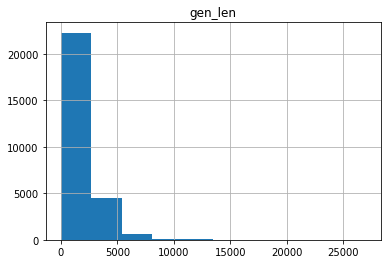

In [12]:
print(df_gl.describe())
df_gl.hist()

In [13]:
from numpy import mean, median
lst_genelng = df_gl['gen_len'].to_list()
lst_genelng.sort()
print(mean(lst_genelng))
print(median(lst_genelng))
print(max(lst_genelng))
print(min(lst_genelng))

1875.863496655216
1561.0
26941
3


## Merge the gene length df with the expr matrix df

In [14]:
## compare number of genes 
print(len(df_expr), len(df_gl))

22426 27655


With **merge** we can join data from 2 df<br>
The **how** argument to merge specifies how to determine which keys are to be included in the resulting table. If a key combination does not appear in either the left or right tables, the values in the joined table will be NA. 
Only the keys appearing in left and right are present (the intersection), since **how='inner'** by default.<br>
https://pandas.pydata.org/docs/user_guide/merging.html

In [15]:
result = pd.merge(df_expr, df_gl, on=["Genes", "Genes"])

In [16]:
len(result)

22426

In [17]:
result.head(5)

,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,gen_len
0,AT1G01020,175,163,108,117,224,92,267,145,1752
1,AT1G01030,20,25,13,13,35,16,22,9,1077
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018,7561
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684,1289
4,AT1G01060,11,4,288,18184,32522,219,835,386,3070


In [18]:
result.iloc[1:10, list(range(4)) + [-1]]

,Genes,healthy30.1,healthy30,healthy12,gen_len
1,AT1G01030,20,25,13,1077
2,AT1G01040,2541,2492,1027,7561
3,AT1G01050,1531,1804,850,1289
4,AT1G01060,11,4,288,3070
5,AT1G01070,39,106,42,1980
6,AT1G01080,1280,1131,975,1287
7,AT1G01090,5079,6032,1281,1462
8,AT1G01100,1458,1088,483,671
9,AT1G01110,8,31,10,2256


In [19]:
# make gene column as index column
df = result.set_index('Genes')
df.head(5)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,gen_len
Genes,,,,,,,,,
AT1G01020,175,163,108,117,224,92,267,145,1752
AT1G01030,20,25,13,13,35,16,22,9,1077
AT1G01040,2541,2492,1027,1324,2376,638,2296,1018,7561
AT1G01050,1531,1804,850,1217,2664,406,1851,684,1289
AT1G01060,11,4,288,18184,32522,219,835,386,3070


## Normalize the raw-counts to TPM values
**We are using the bioinfokit.analys pkg**

In [20]:
# gene length must be in bp
nm = norm()
nm.tpm(df=df, gl='gen_len')
# get TPM normalized dataframe
df_tmp = nm.tpm_norm

In [21]:
df_tmp.head(5)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
Genes,,,,,,,,
AT1G01020,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
AT1G01030,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
AT1G01040,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054
AT1G01050,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331
AT1G01060,0.304,0.100,15.112,715.292,600.107,11.611,21.152,14.058


In [22]:
## chk the result with the total sum by column 
df_tmp.sum(axis = 0, skipna = True) 

healthy30.1    1.000e+06
healthy30      1.000e+06
healthy12      1.000e+06
healthy18.1    1.000e+06
healthy18      1.000e+06
healthy24.1    1.000e+06
healthy12.1    1.000e+06
healthy24      1.000e+06
dtype: float64

In [23]:
df_tmp.to_csv("../results-data/matrices_de_expresion/matrix_B_"+ general_titles.strip() +".csv", index=True, header=True)

In [24]:
df=df_tmp.mean()
lst_tpm = df.to_list()
lst_tpm.sort()
lst_tpm

[44.59109961651613,
 44.591099616516516,
 44.5910996165166,
 44.59109961651672,
 44.59109961651688,
 44.591099616517035,
 44.59109961651705,
 44.59109961651736]

## Get some stats over the normalized array

In [25]:
## Gets some stats on the new filtered array of genes with common zeros
df_plot = df_tmp.describe().T
df_plot.drop(df_plot.tail(1).index,inplace=True) # drop last n rows / or first n rows (.head)
df_plot 

,count,mean,std,min,25%,50%,75%,max
healthy30.1,22426.0,44.591,287.304,0.0,0.797,8.525,27.881,14902.684
healthy30,22426.0,44.591,337.074,0.0,0.654,7.104,25.009,22193.965
healthy12,22426.0,44.591,285.706,0.0,1.482,10.199,29.627,24767.539
healthy18.1,22426.0,44.591,353.710,0.0,0.942,7.839,24.494,29718.510
healthy18,22426.0,44.591,391.117,0.0,0.997,7.393,23.217,36543.769
healthy24.1,22426.0,44.591,362.055,0.0,1.064,8.185,24.213,23032.323
healthy12.1,22426.0,44.591,274.744,0.0,1.248,10.185,30.402,23438.856


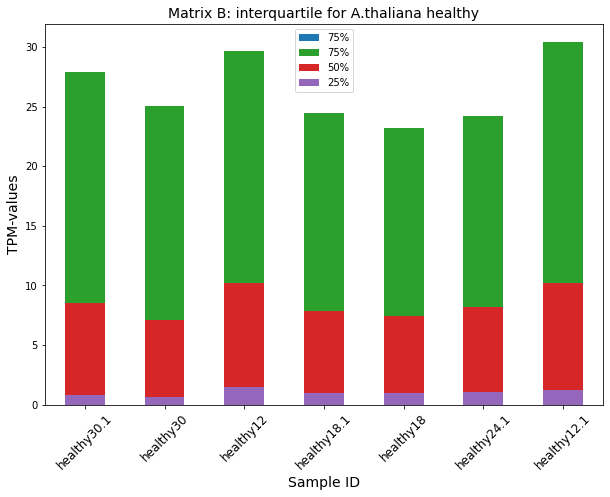

In [26]:
# Plot and save stats for the matrix type A
plot_intercuartile_bar(df_plot, 'Matrix B: interquartile for A.thaliana '+ general_titles,'TPM-values')
df_plot.to_csv("../results-data/statistics/matrix_B_stats_"+ general_titles.strip()+".csv", index=False, header=True)

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


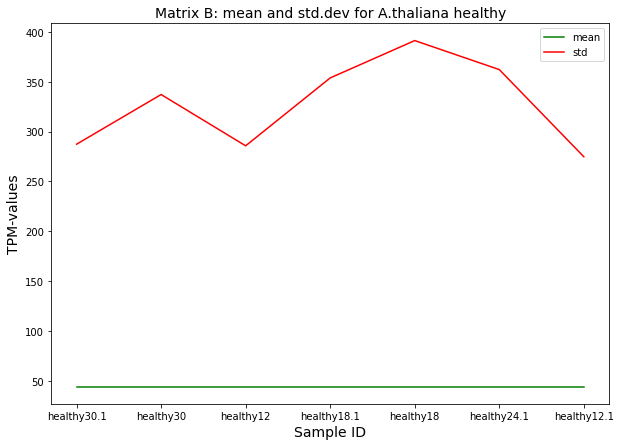

In [27]:
plot_mean_sdev_line(df_plot,'Matrix B: mean and std.dev for A.thaliana '+ general_titles,'TPM-values')

## Check the number of zeros by sample after normalization

In [28]:
sr_ceros = df_tmp.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [29]:
type(sr_ceros)
sr_ceros.sort_values()

healthy18      1660
healthy12.1    1811
healthy24      2132
healthy12      2168
healthy18.1    2399
healthy30.1    2460
healthy30      2472
healthy24.1    2474
dtype: int64

## Check the number of zeros across all sample after normalization
Zeros will be counted by gene across all samples & a new column with the zero-counter will be appended to the matrix.

In [30]:
s_zeros =(df_tmp == 0.000).astype(int).sum(axis=1)
## Added a column to df1 with the counter of zeros
df_tmp['zero-counter'] = s_zeros
df_tmp.head(3)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
Genes,,,,,,,,,
AT1G01020,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254,0
AT1G01030,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934,0
AT1G01040,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054,0


**If you want to check the remaining zeros**

In [31]:
(len(df_tmp.columns)-1)

8

In [32]:
## Filter is looking for genes with 8 zeros across all samples in the healthy df (we have 8 samples for control)
##                   and genes with 17 zeros across all samples in the infected df (we have 17 samples infected)
is_zero = (df_tmp['zero-counter']>=(len(df_tmp.columns)-1))     
df_zero = df_tmp[is_zero]
df_zero.head(7)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
Genes,,,,,,,,,


In [33]:
## Here, we count how many genes are not expressed in all the samples
df_zero.isin([0]).sum().head()

healthy30.1    0
healthy30      0
healthy12      0
healthy18.1    0
healthy18      0
dtype: int64

## Now explore the distributions with the normalized data
Plot all the sample in one plot (histogram and KDE)

In [34]:
# Method one: 
# prepar array from the current df 
#                (Both methods are equivalent)

df_tmp.reset_index(level=0, inplace=True)
df_plot = df_tmp.drop(['Genes','zero-counter'], axis=1)
df_plot.head(3)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054


In [231]:
# Method two: 
# load the created one 
df_plot = pd.read_csv("matrices_de_expresion/matrix_B_" + general_titles.strip() + ".csv", sep=',')  
df_plot.drop(['Genes'], axis=1, inplace = True)
df_plot.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,5.249,10.935,12.218,18.318,15.704,17.520,4.363,20.077,10.350,7.144,11.981,10.415,13.103,12.592,7.542,4.991,13.514
1,7.045,0.757,1.616,1.619,1.277,1.295,7.657,1.149,2.041,4.898,3.086,1.775,1.213,2.682,4.282,5.015,2.250
2,1.733,18.994,14.523,24.521,20.855,19.745,2.820,25.295,19.389,13.905,20.775,14.089,15.131,21.154,13.476,2.517,15.953


In [35]:
df_plot.shape

(22426, 8)

In [36]:
## Get sample list names
sample_lst=df_plot.columns
print(sample_lst)

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


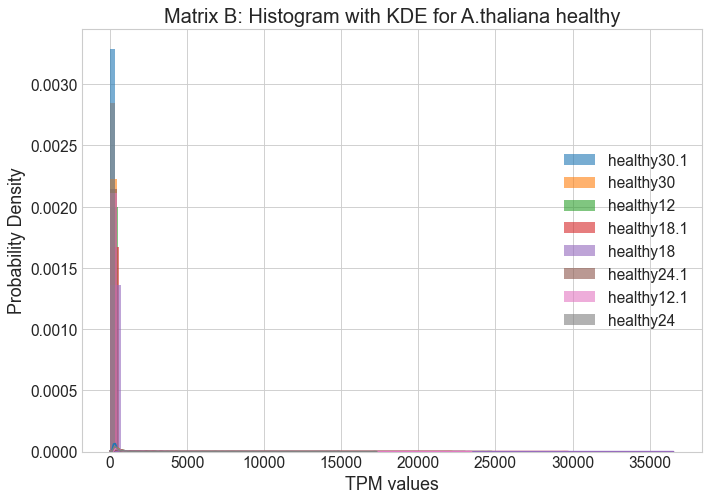

In [37]:
plot_KDE(df_plot, sample_lst, general_titles.strip(), 'TPM values')